In [199]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip3 install geopy 
# uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#!pip3 install folium 
# uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from functools import reduce
print('Libraries imported.')


Libraries imported.


## Data acquisition
#### Latest Population data downloaded from Singapore SingStat website as a csv file

In [23]:
df=pd.read_csv('respopagesextod2011to2020.csv')
df.head()

,PA,SZ,AG,Sex,TOD,Pop,Time
0,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 1- and 2-Room Flats,0,2011
1,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 3-Room Flats,10,2011
2,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 4-Room Flats,30,2011
3,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HDB 5-Room and Executive Flats,50,2011
4,Ang Mo Kio,Ang Mo Kio Town Centre,0_to_4,Males,HUDC Flats (excluding those privatised),0,2011


In [24]:

# Reading only 2020 data
df=df[df['Time']==2020]
df_pop=df[['PA','Pop']]
# Group by Planning Areas PA and take total population. Remove rows with zero population
sing_pop=df_pop.groupby('PA').sum()
print('Before removing 0 populated areas, # of areas {}'.format(sing_pop.shape[0]))
sing_pop=sing_pop[sing_pop['Pop']!=0]
print('Total number of planning areas in Singapore with population: {}'.format(sing_pop.shape[0]))
sing_pop.head()

Before removing 0 populated areas, # of areas 55
Total number of planning areas in Singapore with population: 42


,Pop
PA,
Ang Mo Kio,162670
Bedok,277720
Bishan,87560
Bukit Batok,158510
Bukit Merah,151700


### Area for each PA taken from Wikipedia
#### Removing Non-English Columns. Renaming the column names. Setting Index to Planning Area

In [25]:
url="https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore"
df1=pd.read_html(url)[2]
df1.head()

,Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)
0,Ang Mo Kio,NaN,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,163950,13400
1,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,279380,13000
2,Bishan,NaN,碧山,Bì shān,பீஷான்,Central,7.62,88010,12000
3,Boon Lay,NaN,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6
4,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,153740,14000


In [26]:

df1.drop(columns=['Malay','Chinese','Pinyin','Tamil','Population[7]','Density (/km2)'],axis=1,inplace=True)
df1.rename(columns={'Name (English)':'Planning Area'},inplace=True)
df1.set_index('Planning Area',inplace=True)
df1.head()

,Region,Area (km2)
Planning Area,,
Ang Mo Kio,North-East,13.94
Bedok,East,21.69
Bishan,Central,7.62
Boon Lay,West,8.23
Bukit Batok,West,11.13


### Merging 2020 data with area for common PA

In [29]:
sing_pop1=sing_pop.join(df1,how='left')
sing_pop1.head()

,Pop,Region,Area (km2)
PA,,,
Ang Mo Kio,162670,North-East,13.94
Bedok,277720,East,21.69
Bishan,87560,Central,7.62
Bukit Batok,158510,West,11.13
Bukit Merah,151700,Central,14.34


## projecting ethnic population from 2015 to 2020 
#### Ethnic population data for each PA provided for 2015

In [30]:
pop2015=pd.read_csv('resident-population-by-planning-area-ethnic-group-and-sex.csv')
pop2015.head()

,year,level_1,level_2,level_3,value
0,2015,Total,Total,Total,3902690
1,2015,Total,Total,Ang Mo Kio- Total,174770
2,2015,Total,Total,Bedok- Total,289750
3,2015,Total,Total,Bishan- Total,90700
4,2015,Total,Total,Boon Lay- Total,30


In [31]:


pop2015=pop2015[pop2015['level_2']=='Total']
pop2015.drop(columns=['year','level_2'],axis=1,inplace=True)
pop2015.replace({'level_3':'- Total'},{'level_3':''},regex=True,inplace=True)
pop2015=pop2015[pop2015['level_3']!='Total']
pop2015.set_index('level_3',inplace=True)
pop2015.head()

,level_1,value
level_3,,
Ang Mo Kio,Total,174770
Bedok,Total,289750
Bishan,Total,90700
Boon Lay,Total,30
Bukit Batok,Total,139270


### Separating each ethnic group into different dataframes and then merging as single dataframe

In [32]:
pop_total=pop2015[pop2015['level_1']=='Total']
pop_chinese=pop2015[pop2015['level_1']=='Chinese']
pop_malays=pop2015[pop2015['level_1']=='Malays']
pop_indians=pop2015[pop2015['level_1']=='Indians']
pop_others=pop2015[pop2015['level_1']=='Others']

In [33]:
popf = reduce(lambda left,right: pd.merge(left,right,on='level_3',how='outer'),
                   [pop_total,pop_chinese,pop_malays,pop_indians,pop_others],
                                            ).fillna(0)
# Renaming column names

popf.columns.values[0]='typet'
popf.columns.values[1]='popt'
popf.columns.values[2]='typec'
popf.columns.values[3]='popc'
popf.columns.values[4]='typem'
popf.columns.values[5]='popm'
popf.columns.values[6]='typei'
popf.columns.values[7]='popi'
popf.columns.values[8]='typeo'
popf.columns.values[9]='popo'
popf=popf.astype({'popc':'int64','popm':'int64','popi':'int64','popo':'int64'})
popf.head()

,typet,popt,typec,popc,typem,popm,typei,popi,typeo,popo
level_3,,,,,,,,,,
Ang Mo Kio,Total,174770,Chinese,143290,Malays,13060,Indians,14150,Others,4270
Bedok,Total,289750,Chinese,208880,Malays,43980,Indians,25110,Others,11780
Bishan,Total,90700,Chinese,77220,Malays,3760,Indians,7000,Others,2720
Boon Lay,Total,30,0,0,0,0,0,0,0,0
Bukit Batok,Total,139270,Chinese,102080,Malays,19570,Indians,13730,Others,3900


In [34]:
# Calculating fraction of each ethnic group out of total

ethnic_frac = pd.DataFrame(index=popf.index)
ethnic_frac['Chinese']=popf['popc']/popf['popt']
ethnic_frac['Malay']=popf['popm']/popf['popt']
ethnic_frac['Indians']=popf['popi']/popf['popt']
ethnic_frac['Others']=popf['popo']/popf['popt']


#### Some of the PA during 2015 have 0 values for total ethnic fractions. This might be due to rounding and other possible errors during population census. Removing these PA

In [35]:
ethnic_frac=ethnic_frac[ethnic_frac.sum(axis=1)!=0]
ethnic_frac.shape

(41, 4)

### Merging ethnic fractions with 2020 population for common PA. Removing rows with NaN values

In [37]:
sing_data=sing_pop1.join(ethnic_frac,how='inner')
sing_data.index.name='Planning Area'
sing_data.head()

,Pop,Region,Area (km2),Chinese,Malay,Indians,Others
Planning Area,,,,,,,
Ang Mo Kio,162670,North-East,13.94,0.819878,0.074727,0.080964,0.024432
Bedok,277720,East,21.69,0.720897,0.151786,0.086661,0.040656
Bishan,87560,Central,7.62,0.851378,0.041455,0.077178,0.029989
Bukit Batok,158510,West,11.13,0.732965,0.140518,0.098585,0.028003
Bukit Merah,151700,Central,14.34,0.786768,0.085986,0.097023,0.030223


In [38]:
sing_data['Max']=sing_data[['Chinese','Malay','Indians','Others']].idxmax(axis=1)
sing_data['2nd'] = sing_data[['Chinese','Malay','Indians','Others']].T.apply(lambda x: x.nlargest(2).idxmin())
sing_data.reset_index(inplace=True)
sing_data.head()

,Planning Area,Pop,Region,Area (km2),Chinese,Malay,Indians,Others,Max,2nd
0,Ang Mo Kio,162670,North-East,13.94,0.819878,0.074727,0.080964,0.024432,Chinese,Indians
1,Bedok,277720,East,21.69,0.720897,0.151786,0.086661,0.040656,Chinese,Malay
2,Bishan,87560,Central,7.62,0.851378,0.041455,0.077178,0.029989,Chinese,Indians
3,Bukit Batok,158510,West,11.13,0.732965,0.140518,0.098585,0.028003,Chinese,Malay
4,Bukit Merah,151700,Central,14.34,0.786768,0.085986,0.097023,0.030223,Chinese,Indians


## Obtaining the coordinates of all the planning areas

In [39]:
address = 'Singapore'

geolocator = Nominatim(user_agent="sing_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


In [40]:

latitudes=[]
longitudes=[]
for i in (sing_data["Planning Area"]): 
      
    geolocator= Nominatim(user_agent="sing_explorer") 
    locs = geolocator.geocode(i+', Singapore') 
    if locs!= None:
            # coordinates returned from  
            # function is stored into 
            # two separate list 
            latitudes.append(locs.latitude) 
            longitudes.append(locs.longitude) 
       
    # if coordinate for a city not 
    # found, insert "NaN" indicating  
    # missing value  
    else: 
            latitudes.append(np.nan) 
            longitudes.append(np.nan) 

In [41]:
sing_data['Latitude']=latitudes
sing_data['Longitude']=longitudes
sing_data.head()

,Planning Area,Pop,Region,Area (km2),Chinese,Malay,Indians,Others,Max,2nd,Latitude,Longitude
0,Ang Mo Kio,162670,North-East,13.94,0.819878,0.074727,0.080964,0.024432,Chinese,Indians,1.370080,103.849523
1,Bedok,277720,East,21.69,0.720897,0.151786,0.086661,0.040656,Chinese,Malay,1.323976,103.930216
2,Bishan,87560,Central,7.62,0.851378,0.041455,0.077178,0.029989,Chinese,Indians,1.350986,103.848255
3,Bukit Batok,158510,West,11.13,0.732965,0.140518,0.098585,0.028003,Chinese,Malay,1.349057,103.749591
4,Bukit Merah,151700,Central,14.34,0.786768,0.085986,0.097023,0.030223,Chinese,Indians,1.270439,103.828318


## Map of Singapore and it's planning areas

In [42]:
map_sing = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, region, name in zip(sing_data['Latitude'], sing_data['Longitude'], sing_data['Region'], sing_data['Planning Area']):
    label = '{}, {}'.format(name, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sing)  
    
map_sing

### Defining Foursquare credentials

In [43]:
CLIENT_ID = 'XPT1EJXLWICKQEWPLLQFQY10H2Y2NETZOEZQEK2DOVAEEZSQ' #  Foursquare ID
CLIENT_SECRET = 'BMM2UK0RO05Q0VJKUX2KNBK2Z3RYLCSMYJGKLIQFUSRGIOL3' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [44]:
## Defining a seach radius based on corresponding planning area
import math
sing_data['Radius']=sing_data['Area (km2)'].apply(lambda x: round(np.sqrt(x/math.pi)*1000))

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Planning Area', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
sing_venues = getNearbyVenues(names=sing_data['Planning Area'],
                                   latitudes=sing_data['Latitude'],
                                   longitudes=sing_data['Longitude'],
                              radius=sing_data['Radius']
                                  )

Ang Mo Kio
Bedok
Bishan
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Changi
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Mandai
Marine Parade
Museum
Newton
Novena
Orchard
Outram
Pasir Ris
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Singapore River
Southern Islands
Sungei Kadut
Tampines
Tanglin
Toa Payoh
Western Water Catchment
Woodlands
Yishun


In [47]:
print(sing_venues.shape)
sing_venues.head()


(3393, 7)


,Planning Area,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.37008,103.849523,Bishan - Ang Mo Kio Park,1.362219,103.846250,Park
1,Ang Mo Kio,1.37008,103.849523,FairPrice Xtra,1.369279,103.848886,Supermarket
2,Ang Mo Kio,1.37008,103.849523,Aramsa ~ The Garden Spa,1.362292,103.847602,Spa
3,Ang Mo Kio,1.37008,103.849523,Old Chang Kee,1.369094,103.848389,Snack Place
4,Ang Mo Kio,1.37008,103.849523,MOS Burger,1.369170,103.847831,Burger Joint


In [48]:
print('There are {} uniques categories.'.format(len(sing_venues['Venue Category'].unique())))

There are 304 uniques categories.


### One hot encoding of all Restaurant categories

In [177]:
# one hot encoding
sing_onehot = pd.get_dummies(sing_venues[['Venue Category']], prefix="", prefix_sep="")


sing_onehot.insert(0, 'Planning Area', sing_venues['Planning Area'])
print(sing_onehot.shape)
sing_rest=sing_onehot.filter(regex='Restaurant|Food|BBQ|Burger|(?:\s|^)Pub(?:\s|$)|Noodle|(?:\s|^)Bar(?:\s|$)')
print('Number of restaurant categories: {}'.format(sing_rest.shape[1]))
sing_rest.insert(0, 'Planning Area', sing_onehot['Planning Area'])

sing_rest.head()


(3393, 305)
Number of restaurant categories: 81


,Planning Area,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Beach Bar,Beer Bar,Burger Joint,Cantonese Restaurant,Chinese Aristocrat Restaurant,Chinese Restaurant,Cocktail Bar,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fujian Restaurant,Gay Bar,German Restaurant,Greek Restaurant,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Health Food Store,Hong Kong Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yunnan Restaurant
0,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ang Mo Kio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ang Mo Kio,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [229]:
sing_rest_grouped = sing_rest.groupby('Planning Area').mean().reset_index()
sing_rest_grouped.head()

,Planning Area,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Beach Bar,Beer Bar,Burger Joint,Cantonese Restaurant,Chinese Aristocrat Restaurant,Chinese Restaurant,Cocktail Bar,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fujian Restaurant,Gay Bar,German Restaurant,Greek Restaurant,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Health Food Store,Hong Kong Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yunnan Restaurant
0,Ang Mo Kio,0.00,0.04,0.01,0.03,0.02,0.0,0.0,0.01,0.0,0.0,0.11,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.10,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.04,0.00,0.00,0.01,0.0,0.00,0.01,0.0,0.0,0.01,0.0,0.05,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.0,0.01,0.00,0.0,0.01,0.01,0.0,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0.02,0.01,0.0,0.00,0.00,0.0
1,Bedok,0.02,0.06,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.14,0.00,0.01,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.07,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.02,0.0,0.01,0.0,0.02,0.01,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.06,0.00,0.0,0.00,0.01,0.0,0.00,0.01,0.00,0.00,0.00,0.0,0.0,0.02,0.02,0.0,0.00,0.00,0.0
2,Bishan,0.00,0.04,0.00,0.03,0.02,0.0,0.0,0.01,0.0,0.0,0.10,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.08,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.03,0.00,0.01,0.01,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.03,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.04,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.02,0.01,0.0,0.00,0.00,0.0
3,Bukit Batok,0.01,0.01,0.00,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0.12,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.03,0.0,0.0,0.0,0.08,0.0,0.00,0.0,0.0,0.01,0.00,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.01,0.02,0.0,0.02,0.0,0.05,0.00,0.00,0.01,0.0,0.02,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.02,0.00,0.00,0.0,0.0,0.00,0.03,0.0,0.00,0.00,0.0
4,Bukit Merah,0.00,0.01,0.01,0.00,0.01,0.0,0.0,0.00,0.0,0.0,0.03,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.01,0.01,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.0,0.04,0.01,0.00,0.02,0.0,0.00,0.00,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.0,0.01,0.00,0.02,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.01,0.01,0.0


In [230]:
sing_rest_grouped.shape

(41, 82)

### Top 5 restaurants in each PA

In [231]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [232]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Planning Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sing_rest_sorted = pd.DataFrame(columns=columns)
sing_rest_sorted['Planning Area'] = sing_rest_grouped['Planning Area']

for ind in np.arange(sing_rest_grouped.shape[0]):
    sing_rest_sorted.iloc[ind, 1:] = return_most_common_venues(sing_rest_grouped.iloc[ind, :], num_top_venues)

sing_rest_sorted.head()

,Planning Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ang Mo Kio,Chinese Restaurant,Food Court,Noodle House,Japanese Restaurant,Asian Restaurant
1,Bedok,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Japanese Restaurant
2,Bishan,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House
3,Bukit Batok,Chinese Restaurant,Food Court,Japanese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant
4,Bukit Merah,Japanese Restaurant,Chinese Restaurant,Korean Restaurant,Food Court,Sushi Restaurant


In [233]:
sing_rest_top5=pd.merge(sing_data,sing_rest_sorted,on='Planning Area',how='inner')
sing_rest_top5['Density']=(sing_rest_top5['Pop']/sing_rest_top5['Area (km2)']).round()
sing_rest_top5

,Planning Area,Pop,Region,Area (km2),Chinese,Malay,Indians,Others,Max,2nd,Latitude,Longitude,Radius,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Density
0,Ang Mo Kio,162670,North-East,13.94,0.819878,0.074727,0.080964,0.024432,Chinese,Indians,1.370080,103.849523,2106,Chinese Restaurant,Food Court,Noodle House,Japanese Restaurant,Asian Restaurant,11669.0
1,Bedok,277720,East,21.69,0.720897,0.151786,0.086661,0.040656,Chinese,Malay,1.323976,103.930216,2628,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,12804.0
2,Bishan,87560,Central,7.62,0.851378,0.041455,0.077178,0.029989,Chinese,Indians,1.350986,103.848255,1557,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,11491.0
3,Bukit Batok,158510,West,11.13,0.732965,0.140518,0.098585,0.028003,Chinese,Malay,1.349057,103.749591,1882,Chinese Restaurant,Food Court,Japanese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,14242.0
4,Bukit Merah,151700,Central,14.34,0.786768,0.085986,0.097023,0.030223,Chinese,Indians,1.270439,103.828318,2136,Japanese Restaurant,Chinese Restaurant,Korean Restaurant,Food Court,Sushi Restaurant,10579.0
5,Bukit Panjang,138790,West,8.99,0.742861,0.159894,0.074085,0.023089,Chinese,Malay,1.379149,103.761413,1692,Fast Food Restaurant,Food Court,Asian Restaurant,Sushi Restaurant,Indonesian Restaurant,15438.0
6,Bukit Timah,78180,Central,17.53,0.861421,0.010205,0.049013,0.079361,Chinese,Others,1.354690,103.776372,2362,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Food Court,Italian Restaurant,4460.0
7,Changi,1860,East,40.61,0.474308,0.284585,0.185771,0.055336,Chinese,Malay,1.351080,103.990064,3595,Fast Food Restaurant,Yunnan Restaurant,Chinese Restaurant,Juice Bar,Latin American Restaurant,46.0
8,Choa Chu Kang,192480,West,6.11,0.708140,0.169965,0.094476,0.027477,Chinese,Malay,1.384749,103.744534,1395,Fast Food Restaurant,Food Court,Chinese Restaurant,Italian Restaurant,Food & Drink Shop,31502.0
9,Clementi,92210,West,9.49,0.771581,0.108589,0.082942,0.036997,Chinese,Malay,1.315100,103.765231,1738,Chinese Restaurant,Food Court,Japanese Restaurant,Indian Restaurant,Noodle House,9717.0


In [234]:
sing_rest_grouped['2nd']=sing_rest_top5['2nd']
sing_rest_grouped["2nd"] = sing_rest_grouped["2nd"].astype('category')
sing_rest_grouped["2nd"] = sing_rest_grouped["2nd"].cat.codes
sing_rest_grouped.head()

,Planning Area,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Beach Bar,Beer Bar,Burger Joint,Cantonese Restaurant,Chinese Aristocrat Restaurant,Chinese Restaurant,Cocktail Bar,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fujian Restaurant,Gay Bar,German Restaurant,Greek Restaurant,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Health Food Store,Hong Kong Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sake Bar,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yunnan Restaurant,2nd
0,Ang Mo Kio,0.00,0.04,0.01,0.03,0.02,0.0,0.0,0.01,0.0,0.0,0.11,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.10,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.04,0.00,0.00,0.01,0.0,0.00,0.01,0.0,0.0,0.01,0.0,0.05,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.0,0.01,0.00,0.0,0.01,0.01,0.0,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0.02,0.01,0.0,0.00,0.00,0.0,0
1,Bedok,0.02,0.06,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.14,0.00,0.01,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.07,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.02,0.0,0.01,0.0,0.02,0.01,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.06,0.00,0.0,0.00,0.01,0.0,0.00,0.01,0.00,0.00,0.00,0.0,0.0,0.02,0.02,0.0,0.00,0.00,0.0,1
2,Bishan,0.00,0.04,0.00,0.03,0.02,0.0,0.0,0.01,0.0,0.0,0.10,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.08,0.0,0.01,0.0,0.0,0.00,0.00,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.03,0.00,0.01,0.01,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.03,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.04,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.02,0.01,0.0,0.00,0.00,0.0,0
3,Bukit Batok,0.01,0.01,0.00,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0.12,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.03,0.0,0.0,0.0,0.08,0.0,0.00,0.0,0.0,0.01,0.00,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.01,0.02,0.0,0.02,0.0,0.05,0.00,0.00,0.01,0.0,0.02,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.02,0.00,0.00,0.0,0.0,0.00,0.03,0.0,0.00,0.00,0.0,1
4,Bukit Merah,0.00,0.01,0.01,0.00,0.01,0.0,0.0,0.00,0.0,0.0,0.03,0.01,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.01,0.01,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.0,0.04,0.01,0.00,0.02,0.0,0.00,0.00,0.0,0.0,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.0,0.01,0.00,0.02,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.01,0.01,0.0,0


### K-Mean clsutering of PA based on restaurant categories and 2nd largest ethnic groups

In [235]:
# set number of clusters
kclusters = 3

sing_rest_grouped_clustering = sing_rest_grouped.drop('Planning Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sing_rest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 0, 1, 2, 1, 1, 1])

In [236]:

sse = []
for k in range(1, 11):
    kmeans1 = KMeans(n_clusters=k, random_state=0).fit(sing_rest_grouped_clustering)
    sse.append(kmeans1.inertia_)

C:\Users\Kruthika\AppData\Local\Continuum\anaconda3\envs\climate4\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


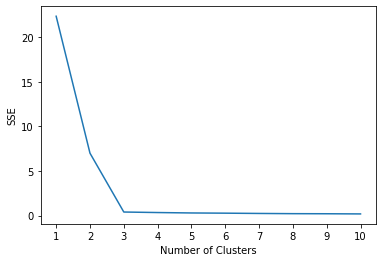

In [237]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [239]:
#sing_rest_top5.drop(columns='Cluster Labels',inplace=True)
# add clustering labels
sing_rest_top5.insert(0, 'Cluster Labels', kmeans.labels_)
sing_rest_top5.astype({'Cluster Labels': 'int64'})
sing_rest_top5.head()

,Cluster Labels,Planning Area,Pop,Region,Area (km2),Chinese,Malay,Indians,Others,Max,2nd,Latitude,Longitude,Radius,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Density
0,0,Ang Mo Kio,162670,North-East,13.94,0.819878,0.074727,0.080964,0.024432,Chinese,Indians,1.370080,103.849523,2106,Chinese Restaurant,Food Court,Noodle House,Japanese Restaurant,Asian Restaurant,11669.0
1,1,Bedok,277720,East,21.69,0.720897,0.151786,0.086661,0.040656,Chinese,Malay,1.323976,103.930216,2628,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,12804.0
2,0,Bishan,87560,Central,7.62,0.851378,0.041455,0.077178,0.029989,Chinese,Indians,1.350986,103.848255,1557,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,11491.0
3,1,Bukit Batok,158510,West,11.13,0.732965,0.140518,0.098585,0.028003,Chinese,Malay,1.349057,103.749591,1882,Chinese Restaurant,Food Court,Japanese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,14242.0
4,0,Bukit Merah,151700,Central,14.34,0.786768,0.085986,0.097023,0.030223,Chinese,Indians,1.270439,103.828318,2136,Japanese Restaurant,Chinese Restaurant,Korean Restaurant,Food Court,Sushi Restaurant,10579.0


In [240]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sing_rest_top5['Latitude'], sing_rest_top5['Longitude'], sing_rest_top5['Planning Area'], sing_rest_top5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [241]:
c1=sing_rest_top5.loc[sing_rest_top5['Cluster Labels'] == 0, sing_rest_top5.columns[[1,2,9,10] + list(range(14, sing_rest_top5.shape[1]))]]
c1

,Planning Area,Pop,Max,2nd,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Density
0,Ang Mo Kio,162670,Chinese,Indians,Chinese Restaurant,Food Court,Noodle House,Japanese Restaurant,Asian Restaurant,11669.0
2,Bishan,87560,Chinese,Indians,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,11491.0
4,Bukit Merah,151700,Chinese,Indians,Japanese Restaurant,Chinese Restaurant,Korean Restaurant,Food Court,Sushi Restaurant,10579.0
12,Hougang,228130,Chinese,Indians,Chinese Restaurant,Food Court,Fast Food Restaurant,Noodle House,Asian Restaurant,16377.0
15,Kallang,101680,Chinese,Indians,Chinese Restaurant,Thai Restaurant,Restaurant,Italian Restaurant,Indian Restaurant,11088.0
16,Mandai,2060,Chinese,Indians,Food Court,Fast Food Restaurant,Malay Restaurant,Noodle House,Dim Sum Restaurant,175.0
17,Marine Parade,46230,Chinese,Indians,Noodle House,Asian Restaurant,Chinese Restaurant,Italian Restaurant,Bar,7554.0
20,Novena,49440,Chinese,Indians,Indian Restaurant,Chinese Restaurant,Food Court,Seafood Restaurant,Noodle House,5506.0
27,Rochor,12730,Chinese,Indians,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Restaurant,Japanese Restaurant,7858.0
31,Serangoon,117070,Chinese,Indians,Chinese Restaurant,Noodle House,Asian Restaurant,Italian Restaurant,Korean Restaurant,11591.0


In [242]:
c2=sing_rest_top5.loc[sing_rest_top5['Cluster Labels'] == 1, sing_rest_top5.columns[[1,2,9,10] + list(range(14, sing_rest_top5.shape[1]))]]
c2

,Planning Area,Pop,Max,2nd,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Density
1,Bedok,277720,Chinese,Malay,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,12804.0
3,Bukit Batok,158510,Chinese,Malay,Chinese Restaurant,Food Court,Japanese Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,14242.0
5,Bukit Panjang,138790,Chinese,Malay,Fast Food Restaurant,Food Court,Asian Restaurant,Sushi Restaurant,Indonesian Restaurant,15438.0
7,Changi,1860,Chinese,Malay,Fast Food Restaurant,Yunnan Restaurant,Chinese Restaurant,Juice Bar,Latin American Restaurant,46.0
8,Choa Chu Kang,192480,Chinese,Malay,Fast Food Restaurant,Food Court,Chinese Restaurant,Italian Restaurant,Food & Drink Shop,31502.0
9,Clementi,92210,Chinese,Malay,Chinese Restaurant,Food Court,Japanese Restaurant,Indian Restaurant,Noodle House,9717.0
11,Geylang,110450,Chinese,Malay,Chinese Restaurant,Food Court,Asian Restaurant,Seafood Restaurant,BBQ Joint,11457.0
13,Jurong East,78840,Chinese,Malay,Chinese Restaurant,Food Court,Japanese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,4422.0
14,Jurong West,263050,Chinese,Malay,Fast Food Restaurant,Food Court,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,17907.0
22,Outram,18330,Chinese,Malay,Chinese Restaurant,Asian Restaurant,Noodle House,Italian Restaurant,Japanese Restaurant,13380.0


In [243]:
c3=sing_rest_top5.loc[sing_rest_top5['Cluster Labels'] == 2, sing_rest_top5.columns[[1,2,9,10] + list(range(14, sing_rest_top5.shape[1]))]]
c3

,Planning Area,Pop,Max,2nd,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Density
6,Bukit Timah,78180,Chinese,Others,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Food Court,Italian Restaurant,4460.0
10,Downtown Core,2970,Chinese,Others,Japanese Restaurant,Italian Restaurant,Cocktail Bar,Modern European Restaurant,Dim Sum Restaurant,684.0
18,Museum,500,Chinese,Others,Japanese Restaurant,Restaurant,Asian Restaurant,Whisky Bar,Bar,602.0
19,Newton,8250,Chinese,Others,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Asian Restaurant,3986.0
21,Orchard,810,Chinese,Others,Japanese Restaurant,Sushi Restaurant,Chinese Restaurant,Asian Restaurant,Indonesian Restaurant,844.0
26,River Valley,10090,Chinese,Others,Japanese Restaurant,Hotpot Restaurant,Chinese Restaurant,Sushi Restaurant,Dumpling Restaurant,6818.0
28,Seletar,280,Chinese,Others,Asian Restaurant,Restaurant,Southern / Soul Food Restaurant,Food Court,Bar,27.0
32,Singapore River,3100,Chinese,Others,Japanese Restaurant,Noodle House,Italian Restaurant,Bar,Food Court,3229.0
33,Southern Islands,1940,Chinese,Others,Yunnan Restaurant,Italian Restaurant,Food & Drink Shop,Food Court,Food Truck,320.0
36,Tanglin,21900,Chinese,Others,French Restaurant,Chinese Restaurant,Italian Restaurant,Modern European Restaurant,Seafood Restaurant,2870.0


### Indian Restaurants in Singapore

In [244]:
sing_indrest=sing_venues[sing_venues['Venue Category']=='Indian Restaurant']
sing_indrest.head()

,Planning Area,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
60,Ang Mo Kio,1.370080,103.849523,R R Indian Food Stall,1.370968,103.836973,Indian Restaurant
138,Bedok,1.323976,103.930216,Saffrons Cafeteria,1.321524,103.924199,Indian Restaurant
161,Bedok,1.323976,103.930216,"Chat Masala, Upper East Coast",1.313958,103.931524,Indian Restaurant
212,Bishan,1.350986,103.848255,Sin Ming Roti Prata (Faisal & Aziz Curry Musli...,1.355269,103.836719,Indian Restaurant
348,Bukit Batok,1.349057,103.749591,Zaffron Kitchen,1.333654,103.742958,Indian Restaurant


In [245]:
sing_onlyind=sing_indrest.groupby('Planning Area').count()
sing_onlyind.drop(columns=['Latitude','Longitude','Venue','Venue Latitude','Venue Longitude'],inplace=True)
sing_onlyind.reset_index(inplace=True)
sing_indian=pd.merge(sing_onlyind,sing_data,on='Planning Area',how='inner')
sing_indian.rename(columns={'Venue Category':'Indian Restaurants'},inplace=True)
sing_indian.drop(columns=['Latitude','Longitude','Radius','Malay','Others','Chinese','Max'],inplace=True)
sing_indian=sing_indian.assign(ind_pop=(sing_indian.loc[:,'Indians']*sing_indian.loc[:,'Pop']).round())
sing_indian=sing_indian.assign(ind_pd=(sing_indian.loc[:,'ind_pop']/sing_indian.loc[:,'Area (km2)']).round())
sing_indian

,Planning Area,Indian Restaurants,Pop,Region,Area (km2),Indians,2nd,ind_pop,ind_pd
0,Ang Mo Kio,1,162670,North-East,13.94,0.080964,Indians,13170.0,945.0
1,Bedok,2,277720,East,21.69,0.086661,Malay,24067.0,1110.0
2,Bishan,1,87560,Central,7.62,0.077178,Indians,6758.0,887.0
3,Bukit Batok,2,158510,West,11.13,0.098585,Malay,15627.0,1404.0
4,Bukit Timah,5,78180,Central,17.53,0.049013,Others,3832.0,219.0
5,Clementi,4,92210,West,9.49,0.082942,Malay,7648.0,806.0
6,Hougang,1,228130,North-East,13.93,0.081148,Indians,18512.0,1329.0
7,Jurong East,2,78840,West,17.83,0.107672,Malay,8489.0,476.0
8,Jurong West,3,263050,West,14.69,0.099355,Malay,26135.0,1779.0
9,Kallang,4,101680,Central,9.17,0.142871,Indians,14527.0,1584.0


### PA with the 2nd Largest ethnic Group as Indians

In [246]:
sing_indian_pa=sing_indian[sing_indian['2nd']=='Indians']
sing_indian_pa.reset_index(drop=True,inplace=True)

sing_indian_pa=sing_indian_pa.assign(ind_pop=(sing_indian_pa.loc[:,'Indians']*sing_indian_pa.loc[:,'Pop']).round())
sing_indian_pa=sing_indian_pa.assign(ind_pd=(sing_indian_pa.loc[:,'ind_pop']/sing_indian_pa.loc[:,'Area (km2)']).round())
sing_indian_pa.astype({'ind_pop':'int64','ind_pd':'int64'})
sing_indian_pa

,Planning Area,Indian Restaurants,Pop,Region,Area (km2),Indians,2nd,ind_pop,ind_pd
0,Ang Mo Kio,1,162670,North-East,13.94,0.080964,Indians,13170.0,945.0
1,Bishan,1,87560,Central,7.62,0.077178,Indians,6758.0,887.0
2,Hougang,1,228130,North-East,13.93,0.081148,Indians,18512.0,1329.0
3,Kallang,4,101680,Central,9.17,0.142871,Indians,14527.0,1584.0
4,Marine Parade,4,46230,Central,6.12,0.123333,Indians,5702.0,932.0
5,Novena,13,49440,Central,8.98,0.087727,Indians,4337.0,483.0
6,Rochor,20,12730,Central,1.62,0.202879,Indians,2583.0,1594.0
7,Serangoon,1,117070,North-East,10.10,0.089003,Indians,10420.0,1032.0


In [253]:
sing_indian.set_index('Planning Area',inplace=True)
sing_indian_pa.set_index('Planning Area',inplace=True)

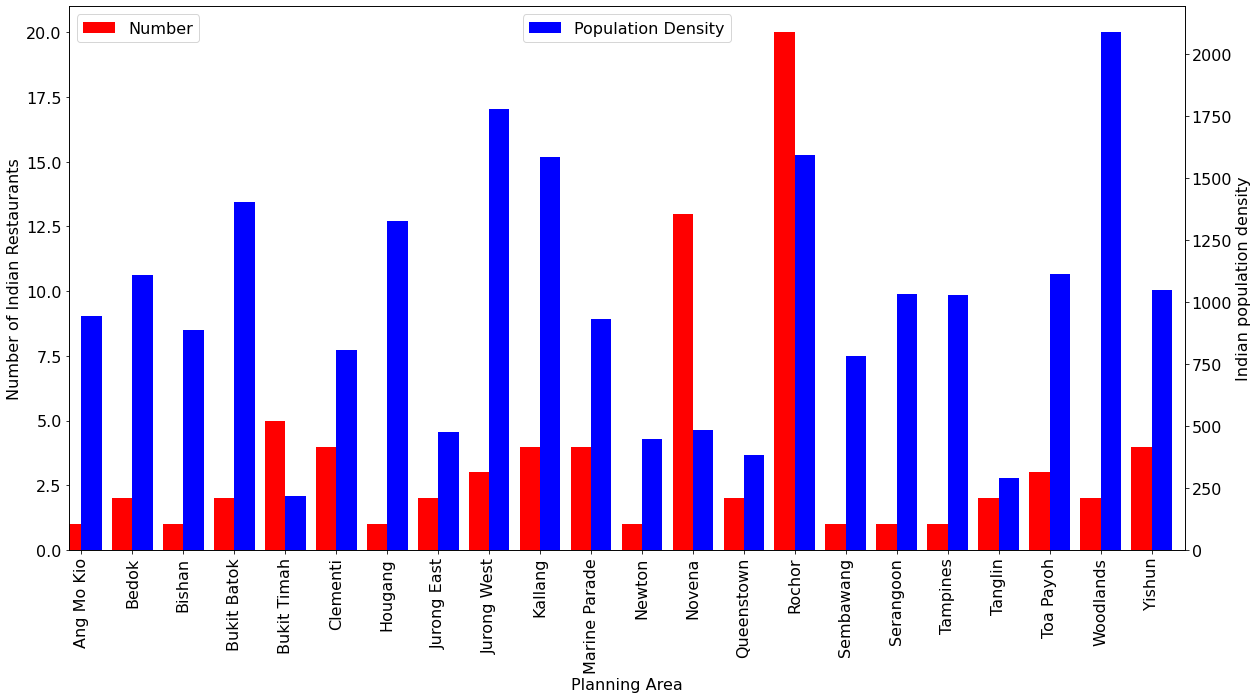

In [274]:

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

sing_indian['Indian Restaurants'].plot(kind='bar', color='red', ax=ax, width=width, position=1,label='Number',fontsize=16)
sing_indian['ind_pd'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0,label='Population Density',fontsize=16)

ax.set_ylabel('Number of Indian Restaurants',fontsize=16)
ax2.set_ylabel('Indian population density',fontsize=16)
ax.legend(loc='upper left',prop={"size":16})
ax2.legend(loc='upper center',prop={"size":16})
ax.set_xlabel('Planning Area',fontsize=16)
plt.show()

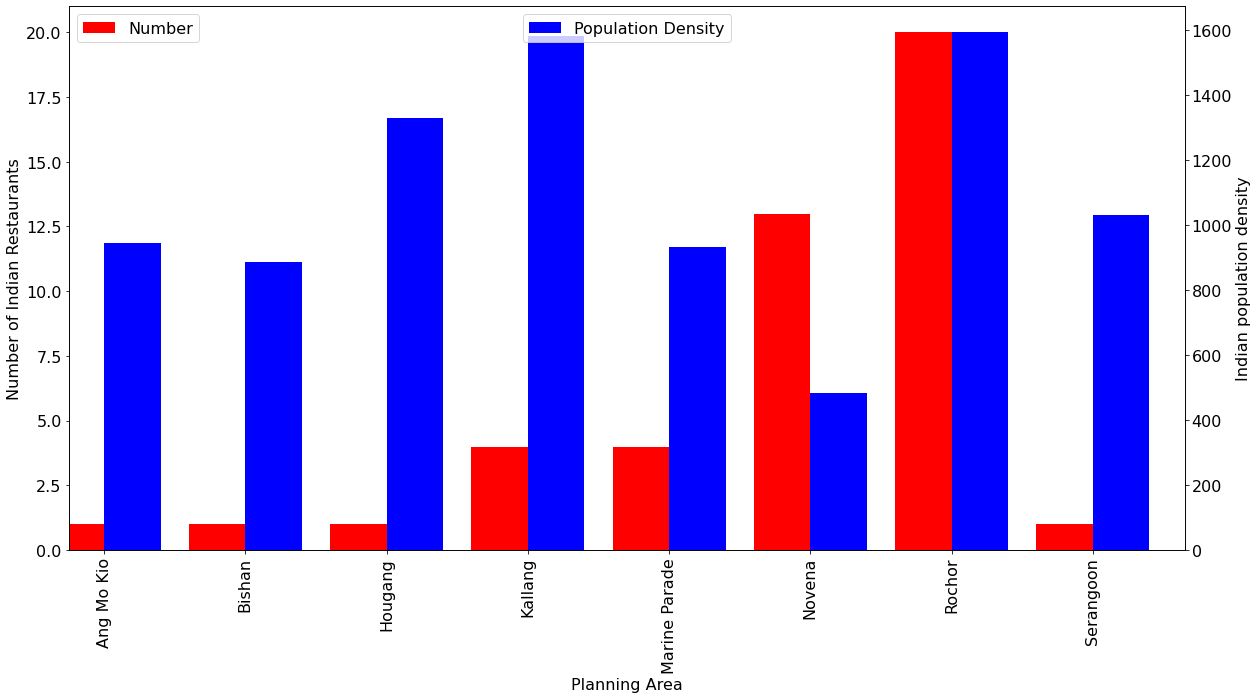

In [275]:
fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

sing_indian_pa['Indian Restaurants'].plot(kind='bar', color='red', ax=ax, width=width, position=1,label='Number',fontsize=16)
sing_indian_pa['ind_pd'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0,label='Population Density',fontsize=16)

ax.set_ylabel('Number of Indian Restaurants',fontsize=16)
ax2.set_ylabel('Indian population density',fontsize=16)
ax.legend(loc='upper left',prop={"size":16})
ax2.legend(loc='upper center',prop={"size":16})
ax.set_xlabel('Planning Area',fontsize=16)
plt.show()